## Approximation using Multi-layers Perceptrons

This code benchmark the approximation of functions using a Multi-Layer Perceptron (MLP) with 2 layers. A MLP with $q$ neurons is defined as
$$
  \forall x \in \mathbb{R}^d, 
 \quad
  f_q(x) \triangleq  \sum_{k=1}^q c_k \phi( \langle x,a_k \rangle + b_k )
$$
where the parameters are 
$(a_k,b_k,c_k) \in \mathbb{R}^{d} \times \mathbb{R} \times \mathbb{R}$, so that the total number of parameters is $q (d+2)$. Here $\phi : \mathbb{R} \to \mathbb{R}$ is a sigmoid function with bounded range (assumed to be $[0,1]$).

The theorem of Barron ensures that for a class of smooth function with 
$$
  \|f\|_B \triangleq
  \int_{\mathbb{R}^d} \|\omega\| |\hat f(\omega)| \text{d} \omega  < +\infty
 $$
and a probability distribution $\mu$ supported on a ball of radius $R$, there exists a neural MLP $f_n$ with $n$ neurons such that

$$
  \int (f(x)-f_q(x))^2 \text{d} \mu(x) 
  = 
  O(\|f\|_B R / \sqrt{q}).
$$

The goal of this tour is to illustrate this theorem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Approximation using gradient descent

Create synthetic data in dimension $d$.

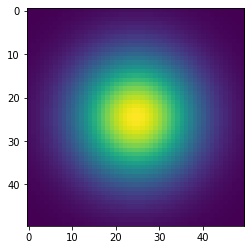

In [4]:
d = 1 
d = 3
d = 2
if d==1:
  n = 256; # #samples
  x = np.linspace(-1,1,n)
  y = np.sin(6*np.pi*np.abs(x)**1.5) + np.abs(x)**2
  x = x[:,None]
  y = y[:,None]
  plt.clf
  plt.plot(x, y);
if d==2:
  n0 = 50
  n = n0**2
  t = np.linspace(-1,1,n0)
  s = .4 # width of the Gaussian
  y = np.exp( - (t[:,None]**2 + t[None,:]**2)/(2*s**2) )
  y = y.flatten()
  [u,v] = np.meshgrid(t,t)
  x = np.concatenate([u.flatten()[:,None],v.flatten()[:,None]], axis=1)
  plt.imshow( np.reshape(y, [n0,n0]) )
if d>2:
  # random point on a cube
  n = 1000
  x = 2*np.random.rand(n,d)-1
  s = .4 # width of the Gaussian
  y = np.exp( - np.sum(x**2, axis=1)/(2*s**2) )
  y = y.flatten()
  plt.plot( np.sum(x, axis=1), y, '.' )

Convert into Torch array of size $(n,d+1)$

In [5]:
X = torch.Tensor(x).to(device)
Y = torch.Tensor(y[:,None]).to(device)

Define a MLP with $q$ hidden neurons.

In [6]:
def create_mlp(q):
  model = nn.Sequential(
        nn.Linear(d, q),
        nn.Tanh(),
        #nn.Sigmoid(),
        #nn.ReLU(),
        nn.Linear(q, 1),
  )
  if torch.cuda.is_available():
      model.cuda()
  return model

Initialize the weights.

In [7]:
def my_init(m):
  nn.init.normal_(m[0].bias, 0, 1)
  nn.init.normal_(m[0].weight, 0,1)
  nn.init.normal_(m[2].bias, 0, 0.001) # set it to 0 for the global bias 
  nn.init.normal_(m[2].weight, 0.0001)

In [8]:
q = 10 # neurons
model = create_mlp(q)
my_init(model)

Define the $\ell^2$ loss function.

In [9]:
loss_func = torch.nn.MSELoss() 
loss = loss_func(model(X), Y)
print( loss.item() )

2.5575342178344727


implementing "by hand" the gradient descent. 

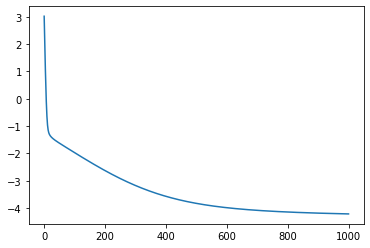

In [13]:
my_init(model)
tau = .01
niter = 1000
L = np.zeros((niter,1))
for i in range(niter):
    loss = loss_func(model(X), Y)
    L[i] = loss.item()
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
      for theta in model.parameters():
        theta -= tau * theta.grad
plt.plot(np.log(L));

Same using Pytorch.

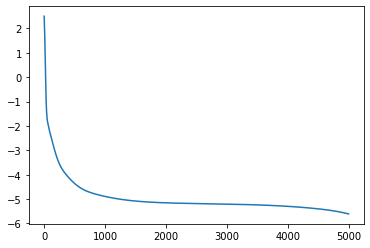

In [14]:
my_init(model)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
model.train()
niter = 5000
L = []
for it in range(niter):
    loss = loss_func(model(X), Y)
    model.zero_grad() # reset the gradient
    loss.backward()
    L.append(loss.item())   
    optimizer.step()
plt.plot(np.log(L));

Quasi-Newton.

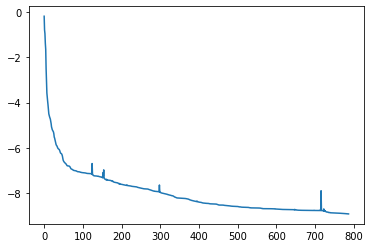

In [15]:
my_init(model)
optimizer = optim.LBFGS(model.parameters());
niter = 40
L = []
for it in range(niter):
  def closure():    
    optimizer.zero_grad() # reset the gradient
    loss = loss_func(model(X), Y)
    model.zero_grad()
    loss.backward()
    L.append(loss.item())    
    return loss
  optimizer.step(closure)
plt.plot(np.log(L));

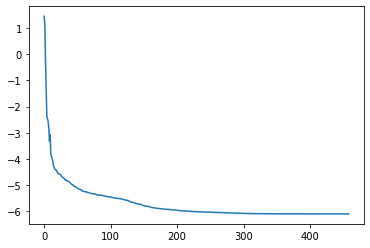

In [ ]:
plt.plot(np.log(L));

Display the repartition of the weights.

Output bias:[0.13394806]


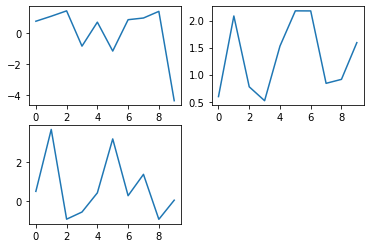

In [20]:
def torch2np(x):
  return x.detach().cpu().numpy()

plt.subplot(2,2,1)
plt.plot(torch2np(model[0].bias))
plt.subplot(2,2,2)
plt.plot( np.std(torch2np(model[0].weight), axis=1) )
plt.subplot(2,2,3)
plt.plot(torch2np(model[2].weight).flatten())
print( 'Output bias:' + str(torch2np(model[2].bias.data)) )

Display the fitted function.

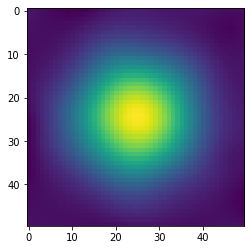

In [21]:
y1 = model(X).detach().cpu().numpy()
if d==1:
  plt.plot(x,y, 'b')
  plt.plot(x,y1, 'r')
if d==2:
  y1 = np.reshape(y1, [n0,n0])
  plt.imshow( y1 )
if d>2:
  plt.plot( np.sum(x, axis=1), y, 'b.' )
  plt.plot( np.sum(x, axis=1), y1, 'r.' )

# Geedy neuron-by-neuron training

In order to illustrate Barron's theorem, we train the network in a greedy fashion, neuron per neuron.

In [22]:
import time
import progressbar

R = Y # residual to fit
qmax = 500 # maximum # neurons
niter = 500 # for the optimizer 

L = [loss_func(R*0, R).item()] # bug, model(X) doit model=0
for iq in progressbar.progressbar(range(qmax)):
  # create a MLP with a single neuron
  model = create_mlp(1)
  my_init(model)
  # be sure to start from 0
  model[2].bias.data=0*model[2].bias.data
  model[2].weight.data=0*model[2].weight.data

  #optimizer = optim.LBFGS(model.parameters());
  #optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  model.train()

  l = []
  for it in range(niter):
    if 0:
      def closure():    
        optimizer.zero_grad() # reset the gradient
        loss = loss_func(model(X), R)
        model.zero_grad()
        loss.backward()
        l.append(loss.item())    
        return loss
      optimizer.step(closure)
    else:
      loss = loss_func(model(X), R)
      model.zero_grad() # reset the gradient
      loss.backward()
      l.append(loss.item())   
      optimizer.step()
    
  # update residual
  L.append( loss_func(model(X), R).item() ) # loss.item())
  R = R - model(X).detach()

100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56


Display the evolution of the loss in log-domain, and compare with the theoretical bound in $O(1/\sqrt{q})$.

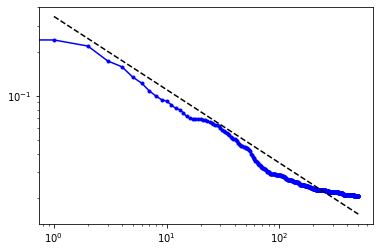

In [24]:
qlist = np.arange(qmax+1)
plt.loglog(qlist, np.sqrt(L), 'b.-')
plt.loglog(qlist[1:], np.sqrt(L[0])/np.sqrt(qlist[1:]), 'k--');